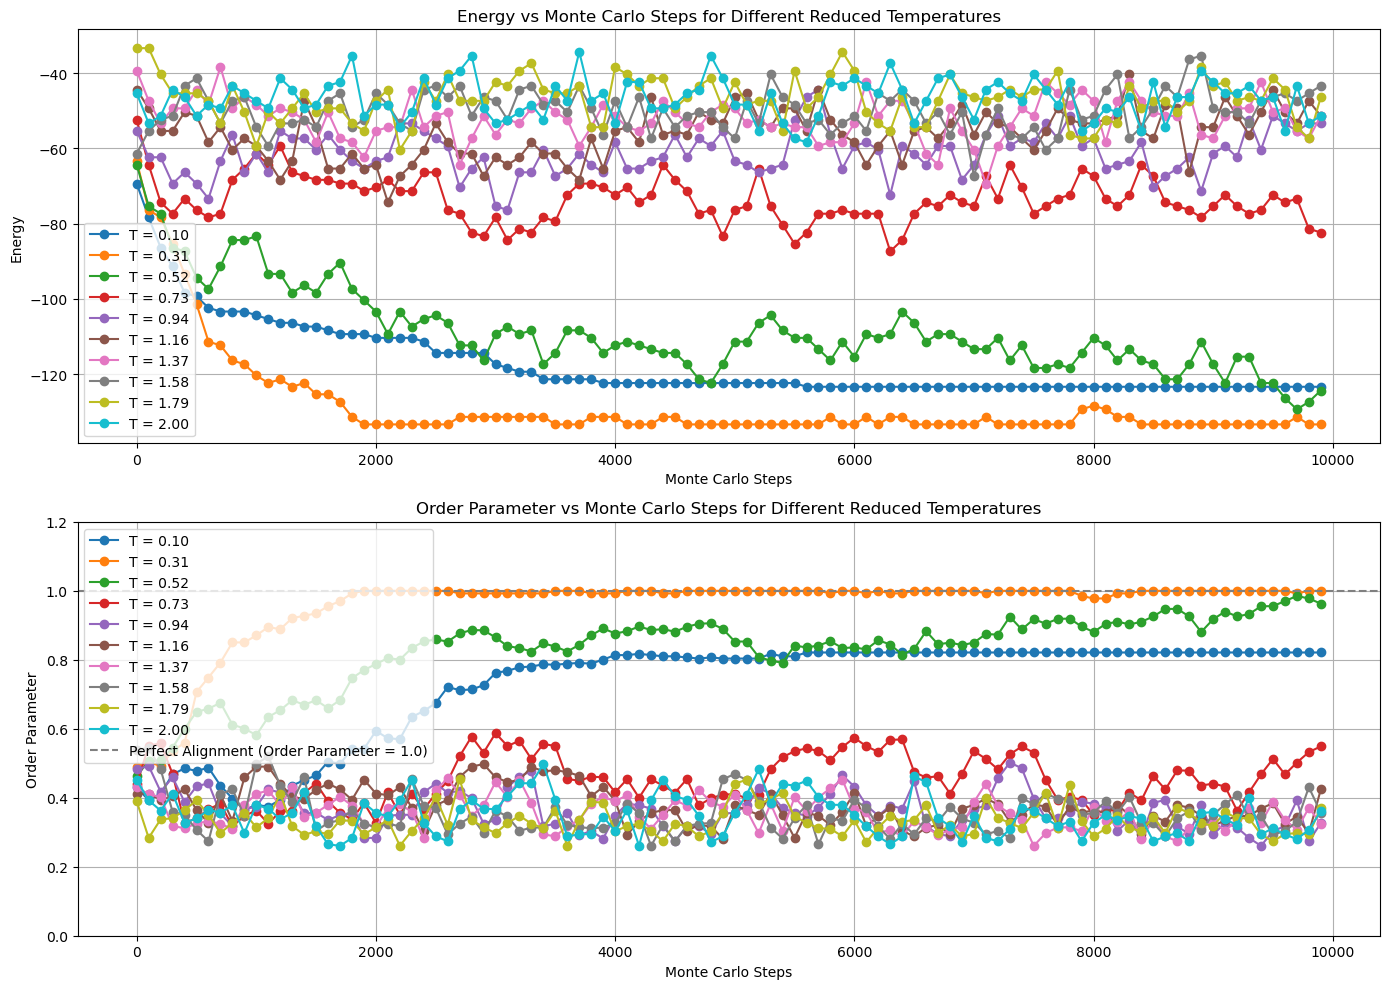

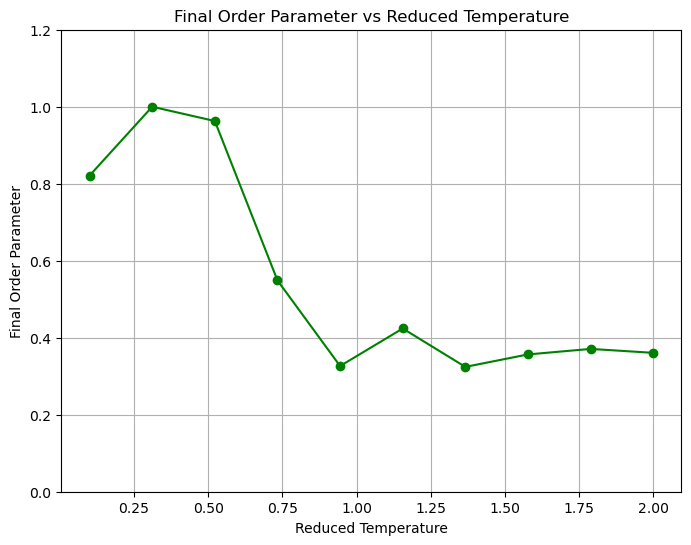

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import circmean

# Constants
N = 10  # Size of the grid (N x N)
epsilon = 1.0  # Interaction strength
k_B = 1.38e-23
steps = 10000  # Number of Monte Carlo steps
reduced_temp_values = np.linspace(0.1, 2.0, 10)  # Range of reduced temperatures

# Possible director angles in radians (0°, 45°, 90°, 135°, 180°)
angles = np.deg2rad([0, 45, 90, 135, 180])

# Initialize directors with random orientations within [0, π)
initial_directors = np.random.choice(angles, size=(N, N))

# Define shifts for periodic boundary conditions
shifts = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def calculate_energy_contributions(directors):
    cos_theta = np.cos(directors)
    sin_theta = np.sin(directors)
    energy = np.zeros_like(directors)

    for dx, dy in shifts:
        cos_shifted = np.roll(cos_theta, shift=(dx, dy), axis=(0, 1))
        sin_shifted = np.roll(sin_theta, shift=(dx, dy), axis=(0, 1))
        cos_diff = cos_theta * cos_shifted + sin_theta * sin_shifted
        energy += -epsilon * (cos_diff**2 - 1/3)
    
    return energy

def calculate_total_energy(energy_contributions):
    return np.sum(energy_contributions) / 2  # Each interaction is counted twice, so divide by 2

def monte_carlo_step(directors, reduced_temp):
    i, j = np.random.randint(N), np.random.randint(N)  # Randomly select a site
    
    # Calculate current energy contributions
    energy_contributions = calculate_energy_contributions(directors)
    current_energy = calculate_total_energy(energy_contributions)
    
    # Flip orientation (rotate by ±45 degrees)
    current_angle = directors[i, j]
    new_angle = current_angle + np.pi / 4 * np.random.choice([-1, 1])
    new_angle = new_angle % np.pi  # Ensure angle is within [0, π)
    
    new_directors = directors.copy()
    new_directors[i, j] = new_angle
    
    # Calculate new energy contributions
    new_energy_contributions = calculate_energy_contributions(new_directors)
    new_energy = calculate_total_energy(new_energy_contributions)
    
    # Metropolis criterion
    delta_E = (new_energy - current_energy) / epsilon
    if delta_E <= 0 or np.random.rand() < np.exp(-delta_E / reduced_temp):
        directors[i, j] = new_angle  # Accept the change
    
    return directors

def calculate_order_parameter(directors):
    # Calculate the circular mean of the directors' angles
    average_angle = circmean(directors.flatten(), high=np.pi)
    aligned_directors = (directors - average_angle + np.pi) % np.pi
    cos_theta = np.cos(aligned_directors)
    order_parameter = np.mean((3 * cos_theta**2 - 1) / 2)
    return order_parameter

def run_simulation(steps, reduced_temp, initial_directors):
    directors = initial_directors.copy()  # Initialize with the same random orientations
    energies = []
    order_parameters = []

    for step in range(steps):
        directors = monte_carlo_step(directors, reduced_temp)
        if (step + 1) % 100 == 0:
            energy_contributions = calculate_energy_contributions(directors)
            energies.append(calculate_total_energy(energy_contributions))
            order_parameters.append(calculate_order_parameter(directors))
    
    final_order_parameter = calculate_order_parameter(directors)
    return directors, energies, order_parameters, final_order_parameter

# Initialize lists to store results for different temperatures
final_order_parameters = []
energy_evolution = []
order_parameter_evolution = []

# Run simulation for different reduced temperatures
for reduced_temp in reduced_temp_values:
    directors_final, energies, order_parameters, final_order_parameter = run_simulation(steps, reduced_temp, initial_directors)
    final_order_parameters.append(final_order_parameter)
    energy_evolution.append((reduced_temp, energies))
    order_parameter_evolution.append((reduced_temp, order_parameters))

# Combined plotting
plt.figure(figsize=(14, 10))

# Plot energy evolution
plt.subplot(2, 1, 1)
for reduced_temp, energies in energy_evolution:
    plt.plot(np.arange(len(energies)) * 100, energies, marker='o', linestyle='-', label=f'T = {reduced_temp:.2f}')
plt.title('Energy vs Monte Carlo Steps for Different Reduced Temperatures')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)

# Plot order parameter evolution
plt.subplot(2, 1, 2)
for reduced_temp, order_parameters in order_parameter_evolution:
    plt.plot(np.arange(len(order_parameters)) * 100, order_parameters, marker='o', linestyle='-', label=f'T = {reduced_temp:.2f}')
plt.axhline(y=1.0, color='gray', linestyle='--', label='Perfect Alignment (Order Parameter = 1.0)')
plt.title('Order Parameter vs Monte Carlo Steps for Different Reduced Temperatures')
plt.xlabel('Monte Carlo Steps')
plt.ylabel('Order Parameter')
plt.ylim(0, 1.2)  # Adjust y-axis limit for better visualization
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the final order parameter vs reduced temperature
plt.figure(figsize=(8, 6))
plt.plot(reduced_temp_values, final_order_parameters, marker='o', linestyle='-', color='g')
plt.title('Final Order Parameter vs Reduced Temperature')
plt.xlabel('Reduced Temperature')
plt.ylabel('Final Order Parameter')
plt.ylim(0, 1.2)  # Adjust y-axis limit for better visualization
plt.grid(True)
plt.show()
